# DAML Project-4: Exotic searches with ATLAS and ML Classification

data from https://cernbox.cern.ch/index.php/s/ZyigdKmH4iezi0g

In [1]:
# Standard imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats
from scipy.stats import zscore
from scipy.special import erfinv

from sklearn.utils import shuffle
import dt_utils
import nn_utils
import seaborn as sns
from sklearn import model_selection, preprocessing

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

Answer_to_all_questions = 42
np.random.seed(Answer_to_all_questions)

## Setup

In [2]:
# Load in the data
dibosonDF = pd.read_csv('Diboson.csv')
ggH1000DF = pd.read_csv('ggH1000.csv')
topDF = pd.read_csv('Top.csv')
zjetsDF = pd.read_csv('Zjets.csv')

In [3]:
# The features we're interested in givnen in notes
features_interest = ['lep1_pt', 'lep2_pt', 'fatjet_pt', 'fatjet_eta', 'fatjet_D2',
                     'Zll_mass', 'Zll_pt', 'MET', 'reco_zv_mass', 'isSignal', 'FullEventWeight']

In [4]:
ggH1000DF.head()

,Unnamed: 0,FullEventWeight,MET,Topology,Zll_mass,Zll_pt,fatjet_C2,fatjet_D2,fatjet_E,fatjet_eta,...,lep1_eta,lep1_phi,lep1_pt,lep2_E,lep2_charge,lep2_eta,lep2_phi,lep2_pt,reco_zv_mass,truth_zv_mass
0,0,0.013603,44495.770,1,87475.55,627990.80,0.116438,0.889354,675246.25,-0.851387,...,-0.906080,-1.876361,320104.62,495510.120,-1,-1.034808,-1.631069,312638.44,1063465.80,999999.56
1,1,0.242178,34441.156,1,90507.31,409780.94,0.191874,1.485706,604275.70,1.041311,...,2.363212,2.032987,288589.78,579769.560,1,2.178999,2.466579,129548.62,974210.75,1000003.60
2,2,0.096412,21625.379,0,89765.85,344668.30,0.122089,1.219367,612517.94,0.417858,...,1.217848,0.664946,228625.23,333899.970,-1,1.695172,0.920596,118590.28,996837.40,999999.80
3,3,0.096373,21855.973,1,92313.63,535629.06,0.061306,0.592705,482630.90,0.438590,...,-0.045790,-0.626280,302502.84,243535.750,1,0.293053,-0.557273,233439.89,989655.56,1000008.80
4,4,0.073052,33677.380,1,89451.92,296257.47,0.159334,0.724910,459737.80,1.213717,...,-1.289961,2.238501,224785.02,98477.516,-1,-0.747040,2.647597,76205.98,993398.30,1000011.90


In [5]:
dibosonDF = dibosonDF[features_interest]
dibosonDF2 = dibosonDF[(np.abs(zscore(dibosonDF.iloc[:, :-2])) < 3).all(axis=1)]
ggH1000DF = ggH1000DF[features_interest]
ggH1000DF2 = ggH1000DF[(np.abs(zscore(ggH1000DF.iloc[:, :-2])) < 3).all(axis=1)]
topDF = topDF[features_interest]
topDF2 = topDF[(np.abs(zscore(topDF.iloc[:, :-2])) < 3).all(axis=1)]
zjetsDF = zjetsDF[features_interest]
zjetsDF2 = zjetsDF[(np.abs(zscore(zjetsDF.iloc[:, :-2])) < 3).all(axis=1)]

In [6]:
# Cuts and whether it is mostly signal or background above or below
sqcuts = np.array([200000, 75000, 330000,
                   -2.0,   1.7,   80000,
                   310000, 70000])
signal_above = np.array([True, True, True,
                         True, False, True,
                         True, False])
background_above = np.array([False, False, False,
                             True, True, False,
                             False, True])

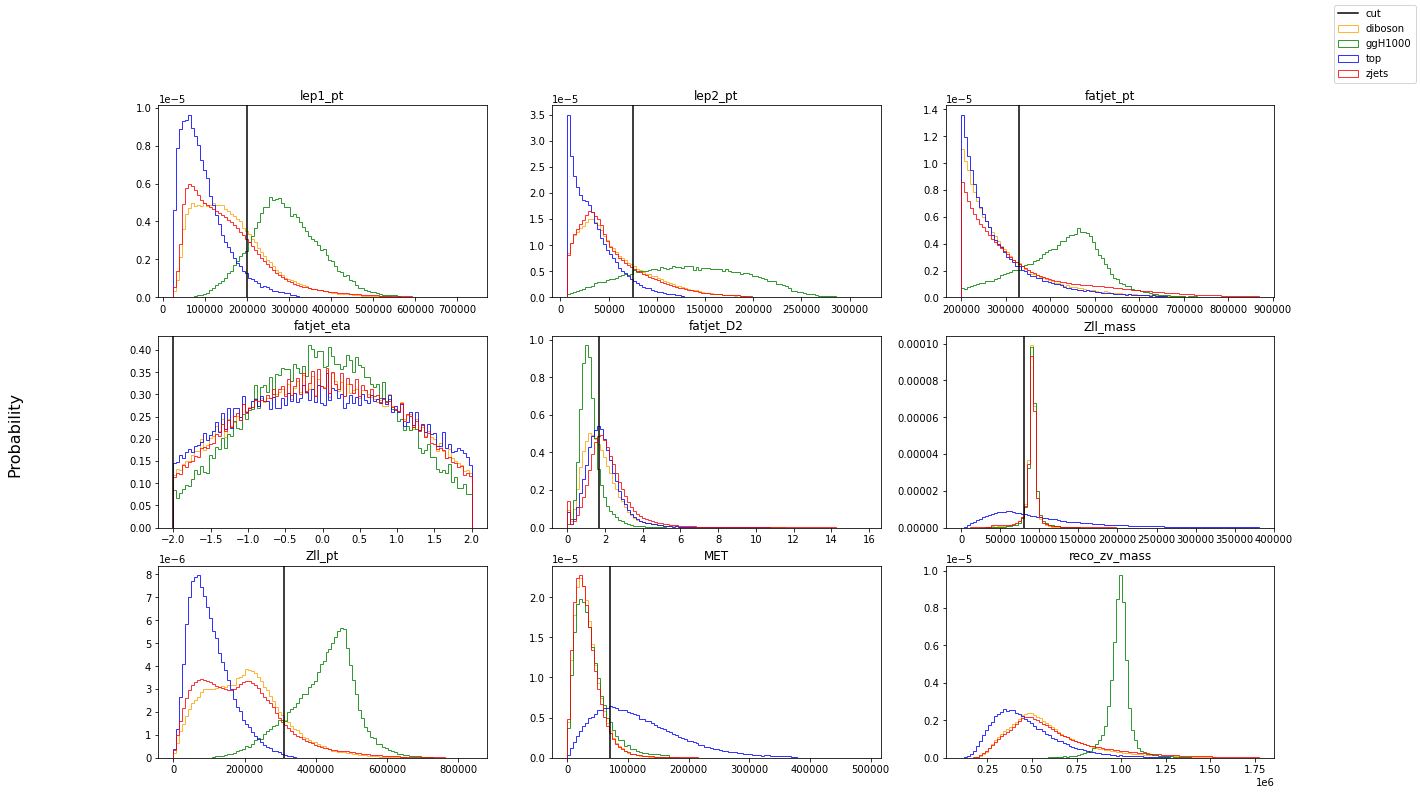

In [7]:
# Plot feature distributions
fig, axs = plt.subplots(3, 3, figsize=(20, 12))
fig.supylabel('Probability', fontsize=16)
n_bins = 100
feat = 0
for i in range(len(axs)):
    for j in range(len(axs[0])):  
        # Plot all 4 on same axis as different colours
        axs[i, j].hist([zjetsDF2[features_interest[feat]],
                       topDF2[features_interest[feat]],
                       ggH1000DF2[features_interest[feat]],
                       dibosonDF2[features_interest[feat]]],
                       bins=n_bins, density=True, alpha=0.8,
                       color=['red', 'blue', 'green', 'orange'],
                       label=['diboson', 'ggH1000', 'top', 'zjets'],
                       histtype='step')
        axs[i, j].set_title(features_interest[feat])
        if not features_interest[feat] == 'reco_zv_mass':
            axs[i, j].axvline(sqcuts[feat], color='k')
        feat += 1
fig.legend(['cut','diboson', 'ggH1000', 'top', 'zjets'])
plt.show()

These cuts dicard any background on the same side as the signal peak and any signal on the other side of the cuts. I realised later that these cuts are really harsh and probably unrealistic. For example, in the Zll_mass, almost all of the green orange background datasets are discarded, same with MET.

In [8]:
signal_df2 = ggH1000DF2.copy()
background_df2 = pd.concat([dibosonDF2, topDF2, zjetsDF2], ignore_index=True)
# Combine into one df
full_df2 = pd.concat([background_df2, signal_df2], ignore_index=True)

In [9]:
# Cut the data by vertical cuts on above graphs
def cut_data(data, cuts, cut_above):
    for i in range(len(features_interest[:8])):
        if cut_above[i]:
            data = data[data[features_interest[i]] >= cuts[i]]
        else:
            data = data[data[features_interest[i]] < cuts[i]]
    return data

In [10]:
# Make the cuts
signal_df2_cut = cut_data(signal_df2, sqcuts, signal_above)
background_df2_cut = cut_data(background_df2, sqcuts, background_above)
full_df2_cut = pd.concat([background_df2_cut, signal_df2_cut], ignore_index=True)

In [11]:
# To plot pre and post cut data
def plot_sig_bkgd(axs_i, signal_data, background_data, full_data):
    n_bins = 100
    axs_i[0].set_title('Signal')
    axs_i[0].hist(signal_data['reco_zv_mass'], bins=n_bins, weights=signal_data['FullEventWeight'],
                  label=str(len(signal_data.index))+' events')
    axs_i[0].legend()
    axs_i[1].set_title('Background')
    axs_i[1].hist(background_data['reco_zv_mass'], bins=n_bins, weights=background_data['FullEventWeight'],
                  label=str(len(background_data.index))+' events')
    axs_i[1].legend()
    axs_i[2].set_title('Signal + Background')
    axs_i[2].hist(full_data['reco_zv_mass'], bins=n_bins, weights=full_data['FullEventWeight'],
                  label=str(len(full_data.index))+' events')
    axs_i[2].legend()

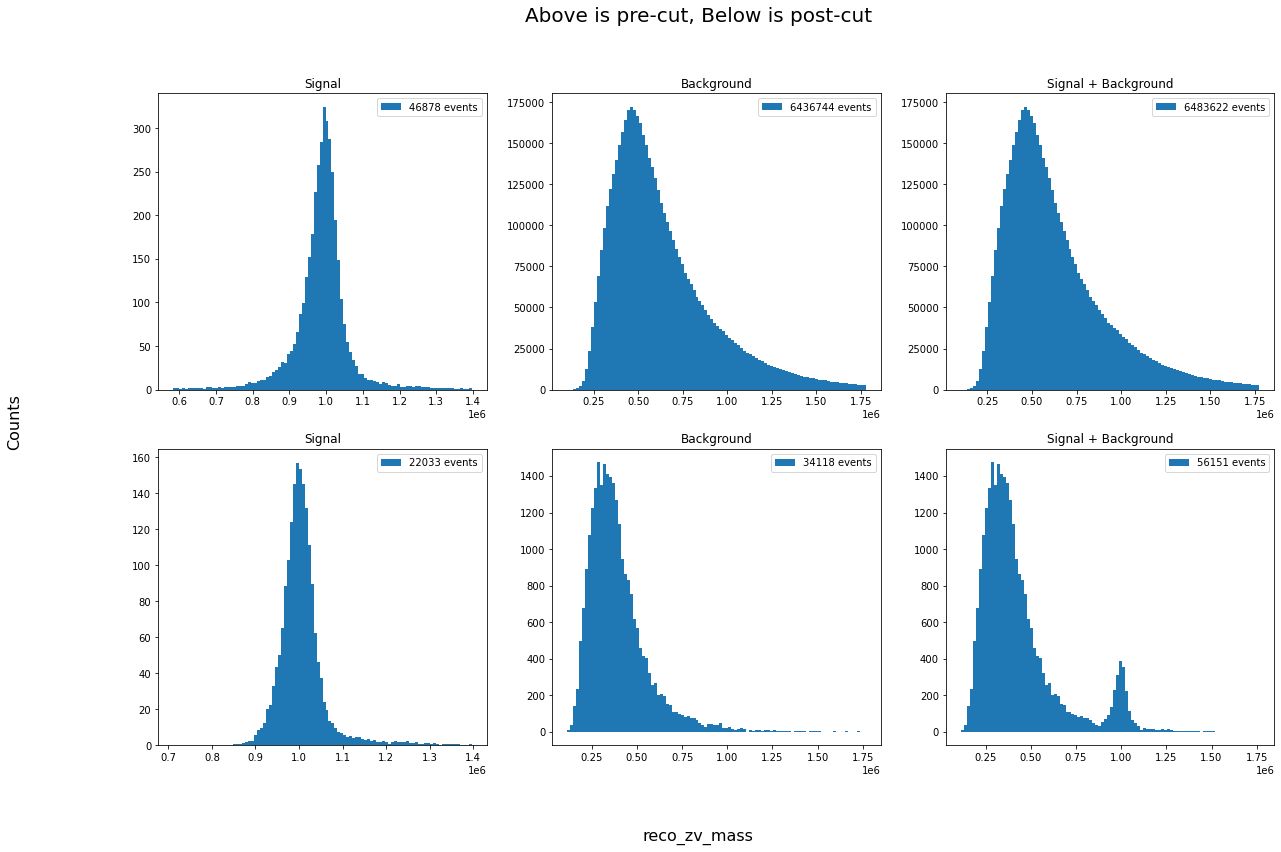

In [12]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Above is pre-cut, Below is post-cut', fontsize=20)
fig.supylabel('Counts', fontsize=16)
fig.supxlabel('reco_zv_mass', fontsize=16)
plot_sig_bkgd(axs[0], signal_df2, background_df2, full_df2)
plot_sig_bkgd(axs[1], signal_df2_cut, background_df2_cut, full_df2_cut)
plt.show()

We can see that these reduce the signal points by about half but the background data is reduced massively, so the signal peak is easily visible after the cuts.

## Fitting and hypothesis-testing

In [13]:
from iminuit import Minuit

In [14]:
# As recommended, set reco_zv_mass ranges for fitting
range_low = 0.5e6
range_high = 1.1e6

In [15]:
# Cut data again by above ranges
background_range_data = background_df2_cut[background_df2_cut['reco_zv_mass'] > range_low]
background_range_data = background_range_data[background_range_data['reco_zv_mass'] < range_high]
signal_range_data = signal_df2_cut[signal_df2_cut['reco_zv_mass'] > range_low]
signal_range_data = signal_range_data[signal_range_data['reco_zv_mass'] < range_high]
full_range_data = pd.concat([background_range_data, signal_range_data], ignore_index=True)

In [16]:
# Returns sum of weights in each bin as well as sum of squares for use later in chi2
def calc_sumsq_weights(bin_edges, weights, bin_indices):
    sum_binned_weights = []
    sumsq_binned_weights = []
    for i in range(len(bin_edges)-1):
        binned_weights_i = np.array(weights)[np.where(bin_indices==i+1)]
        sum_binned_weights.append(np.sum(binned_weights_i))
        sumsq_binned_weights.append(np.sum(binned_weights_i**2))
    return np.array(sum_binned_weights), np.array(sumsq_binned_weights)

In [17]:
# Set bin edges for plotting background (b), signal (s) and full (f) data
bin_edges_b = np.linspace(range_low, range_high, 100)
bin_edges_s = np.linspace(0.9e6, 1.1e6, 100)
bin_edges_f = np.linspace(range_low, range_high, 100)

In [18]:
# Make the histograms and get the binned weights and squared weights
N_obs_b, _ = np.histogram(background_range_data['reco_zv_mass'],
                          weights=background_range_data['FullEventWeight'],
                          bins=bin_edges_b)
# Digitize finds indices of weights in original data included in each bin
bin_indices_b = np.digitize(background_range_data['reco_zv_mass'], bin_edges_b)
sum_binned_weights_b, sumsq_binned_weights_b = calc_sumsq_weights(bin_edges_b,
                                                                  background_range_data['FullEventWeight'],
                                                                  bin_indices_b)
N_obs_s, _ = np.histogram(signal_range_data['reco_zv_mass'],
                          weights=signal_range_data['FullEventWeight'],
                          bins=bin_edges_s)
bin_indices_s = np.digitize(signal_range_data['reco_zv_mass'], bin_edges_s)
sum_binned_weights_s, sumsq_binned_weights_s = calc_sumsq_weights(bin_edges_s,
                                                                  signal_range_data['FullEventWeight'],
                                                                  bin_indices_s)
N_obs_f, _ = np.histogram(full_range_data['reco_zv_mass'],
                          weights=full_range_data['FullEventWeight'],
                          bins=bin_edges_f)
bin_indices_f = np.digitize(full_range_data['reco_zv_mass'], bin_edges_f)
sum_binned_weights_f, sumsq_binned_weights_f = calc_sumsq_weights(bin_edges_f,
                                                                  full_range_data['FullEventWeight'],
                                                                  bin_indices_f)

# Empty bins meant the sum of square weights would be zero and break chi2 so just set to really small values instead
sumsq_binned_weights_s[sumsq_binned_weights_s==0] = 1e-9
sumsq_binned_weights_b[sumsq_binned_weights_b==0] = 1e-9
sumsq_binned_weights_f[sumsq_binned_weights_f==0] = 1e-9

In [19]:
def gaussian_signal_func(mu, sigma, Ns):
    gaussian = np.exp(-0.5 * ((bin_edges_s[:-1] - mu)/sigma)**2)
    return Ns*gaussian

def exp_background_func(k, Nb):
    expdecay = np.exp(-k*bin_edges_b[:-1])
    return Nb*expdecay

# Null hypothesis H0 just includes background
def H0_func(k, Nb):
    expdecay = np.exp(-k*bin_edges_f[:-1])
    return Nb*expdecay
# H1 includes signal too
def H1_func(k, Ns, Nb):
    gaussian = np.exp(-0.5 * ((bin_edges_f[:-1] - mu_best)/sigma_best)**2)
    expdecay = np.exp(-k*bin_edges_f[:-1])
    return Ns*gaussian + Nb*expdecay

In [20]:
def chi2_signal(mu, sigma, Ns):
    N_pred = gaussian_signal_func(mu, sigma, Ns)
    return np.sum(((sum_binned_weights_s - N_pred)**2) / sumsq_binned_weights_s)

def chi2_background(k, Nb):
    N_pred = exp_background_func(k, Nb)
    return np.sum(((sum_binned_weights_b - N_pred)**2) / sumsq_binned_weights_b)

def chi2_H0_func(k, Nb):
    N_pred = H0_func(k, Nb)
    return np.sum(((sum_binned_weights_f - N_pred)**2) / sumsq_binned_weights_f)

def chi2_H1_func(k, Ns, Nb):
    N_pred = H1_func(k, Ns, Nb)
    return np.sum(((sum_binned_weights_f - N_pred)**2) / sumsq_binned_weights_f)

In [21]:
# fit with minutuit given reasonable initial guesses
fit1 = Minuit(chi2_signal, mu=1000000, sigma=30000, Ns=40.)
# definition of error for chi2 given in notes
fit1.errordef = 1.0
fit1.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 351.5                      │              Nfcn = 66               │
│ EDM = 2.58e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬───────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name  │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼───────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ mu    │ 997.30e3  │  0.28e3   │            │            │         │         │       │
│ 1 │ sigma │  33.39e3  │  0.25e3   │            │            │         │         │       │
│ 2 │ Ns    │   41.2    │    0.5    │            │            │         │         │       │
└───┴───────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───────┬───────────────────────────────┐
│       │        mu     sigma        Ns │
├───────┼───────────────────────────────┤
│    mu │  7.58e+04 -9.37e+03      10.8 │
│ sigma │ -9.37e+03  6.42e+04     -78.8 │
│    Ns │      10.8     -78.8      0.21 │
└───────┴───────────────────────────────┘

In [22]:
# parameter best estimates and errors for (i)
mu_best = fit1.values["mu"]
sigma_best = fit1.values["sigma"]
Ns_fit1 = fit1.values["Ns"]

In [23]:
# fit with minutuit given reasonable initial guesses
fit2 = Minuit(chi2_background, k=6e-6, Nb=8000)
# definition of error for chi2 given in notes
fit2.errordef = 1.0
fit2.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 98.55                      │              Nfcn = 73               │
│ EDM = 1.05e-06 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ k    │  6.91e-6  │  0.16e-6  │            │            │         │         │       │
│ 1 │ Nb   │   5.8e3   │   0.6e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │        k       Nb │
├────┼───────────────────┤
│  k │  2.5e-14 9.25e-05 │
│ Nb │ 9.25e-05 3.54e+05 │
└────┴───────────────────┘

In [24]:
k_fit2 = fit2.values["k"]
Nb_fit2 = fit2.values["Nb"]

In [25]:
# fit with minutuit given reasonable initial guesses
fit3 = Minuit(chi2_H0_func, k=6e-6, Nb=8000)
# definition of error for chi2 given in notes
fit3.errordef = 1.0
fit3.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 5028                       │              Nfcn = 165              │
│ EDM = 5.75e-07 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ k    │  1.28e-6  │  0.09e-6  │            │            │         │         │       │
│ 1 │ Nb   │    132    │    11     │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬───────────────────┐
│    │        k       Nb │
├────┼───────────────────┤
│  k │ 8.05e-15 9.39e-07 │
│ Nb │ 9.39e-07      112 │
└────┴───────────────────┘

In [26]:
k_H0fit = fit2.values["k"]
Nb_H0fit = fit2.values["Nb"]

In [27]:
# fit with minutuit given reasonable initial guesses
fit4 = Minuit(chi2_H1_func, k=6e-6, Ns=100, Nb=8000)
# definition of error for chi2 given in notes
fit4.errordef = 1.0
fit4.migrad()

┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 214.3                      │              Nfcn = 110              │
│ EDM = 7.13e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ k    │  6.87e-6  │  0.19e-6  │            │            │         │         │       │
│ 1 │ Ns   │   126.2   │    1.6    │            │            │         │         │       │
│ 2 │ Nb   │   5.7e3   │   0.7e3   │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌────┬────────────────────────────┐
│    │        k       Ns       Nb │
├────┼────────────────────────────┤
│  k │ 3.46e-14 1.14e-07 0.000124 │
│ Ns │ 1.14e-07     2.61      390 │
│ Nb │ 0.000124      390 4.55e+05 │
└────┴────────────────────────────┘

In [28]:
k_H1fit = fit4.values["k"]
Ns_H1fit = fit4.values["Ns"]
Nb_H1fit = fit4.values["Nb"]

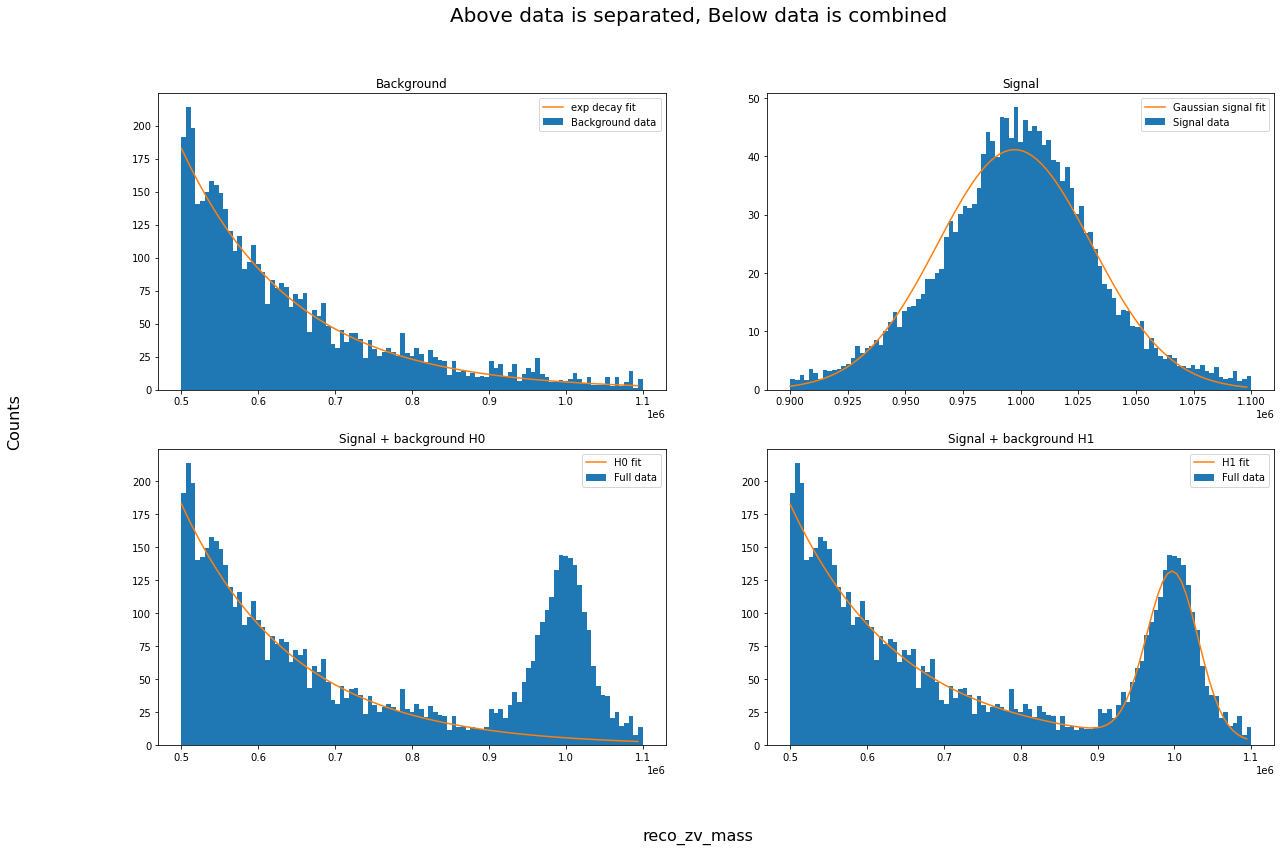

In [29]:
# Plot the data with fits on top
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Above data is separated, Below data is combined', fontsize=20)
fig.supylabel('Counts', fontsize=16)
fig.supxlabel('reco_zv_mass', fontsize=16)
axs[0,0].set_title('Background')
axs[0,0].hist(background_range_data['reco_zv_mass'],
              weights=background_range_data['FullEventWeight'],
              bins=bin_edges_b,
              label='Background data')
axs[0,0].plot(bin_edges_b[:-1], exp_background_func(k_fit2, Nb_fit2), label='exp decay fit')
axs[0,0].legend()

axs[0,1].set_title('Signal')
axs[0,1].hist(signal_range_data['reco_zv_mass'],
              weights=signal_range_data['FullEventWeight'],
              bins=bin_edges_s,
              label='Signal data')
axs[0,1].plot(bin_edges_s[:-1], gaussian_signal_func(mu_best, sigma_best, Ns_fit1), label='Gaussian signal fit')
axs[0,1].legend()

axs[1,0].set_title('Signal + background H0')
axs[1,0].hist(full_range_data['reco_zv_mass'],
              weights=full_range_data['FullEventWeight'],
              bins=bin_edges_f,
              label='Full data')
axs[1,0].plot(bin_edges_f[:-1], H0_func(k_H0fit, Nb_H0fit), label='H0 fit')
axs[1,0].legend()

axs[1,1].set_title('Signal + background H1')
axs[1,1].hist(full_range_data['reco_zv_mass'],
              weights=full_range_data['FullEventWeight'],
              bins=bin_edges_f,
              label='Full data')
axs[1,1].plot(bin_edges_f[:-1], H1_func(k_H1fit, Ns_H1fit, Nb_H1fit), label='H1 fit')
axs[1,1].legend()
plt.show()

In [30]:
delta_chi2 = chi2_H0_func(k_H0fit, Nb_H0fit) - chi2_H1_func(k_H1fit, Ns_H1fit, Nb_H1fit)
p_value = scipy.stats.chi2.cdf(delta_chi2, df=1)
n_sigmas = erfinv(p_value) * np.sqrt(2)

Wilk's theorem tells us that the fact that the H1 and H0 differ by 1 free parameter, the delta chi2 follows a chi2 distribution with one dof.

In [31]:
delta_chi2

7250.408154388558

In [32]:
p_value

1.0

In [33]:
n_sigmas

inf

The p value here is if we assume H0, ie no signal and any peaks are just caused by chance background flucuations, and get the probability of seeing data less extreme than we do. Therefore, p value = 1 means we should always expect data to be more alligned with H0 than it is meaning H1 is overwhelmingly preferred. This is clear even by eye as, due to the harsh cuts, the peak is very obvious.

## Employing a NN classifier

What you will see is we start by taking the data before any kinematic cuts and find that the NN still can't identify a peak. So we take less harch cuts than before and try the same thing.

In [34]:
NN_signal_df = signal_df2.copy()
NN_background_df = background_df2.copy()
NN_full_df = full_df2.copy()
NN_background_df = shuffle(NN_background_df, random_state=Answer_to_all_questions)
NN_background_df = NN_background_df.reset_index(drop=True)

In [35]:
# 50-50 mix of signal and background data points
NN_training_df = pd.concat([NN_signal_df, NN_background_df.iloc[:NN_signal_df.shape[0]]], ignore_index=True)
NN_training_df = shuffle(NN_training_df, random_state=Answer_to_all_questions)
NN_training_df = NN_training_df.reset_index(drop=True)

In [36]:
NN_training_df[NN_training_df['isSignal']==1].shape[0]

46878

In [37]:
NN_training_df2 = NN_training_df.drop(['reco_zv_mass', 'FullEventWeight'], axis=1)

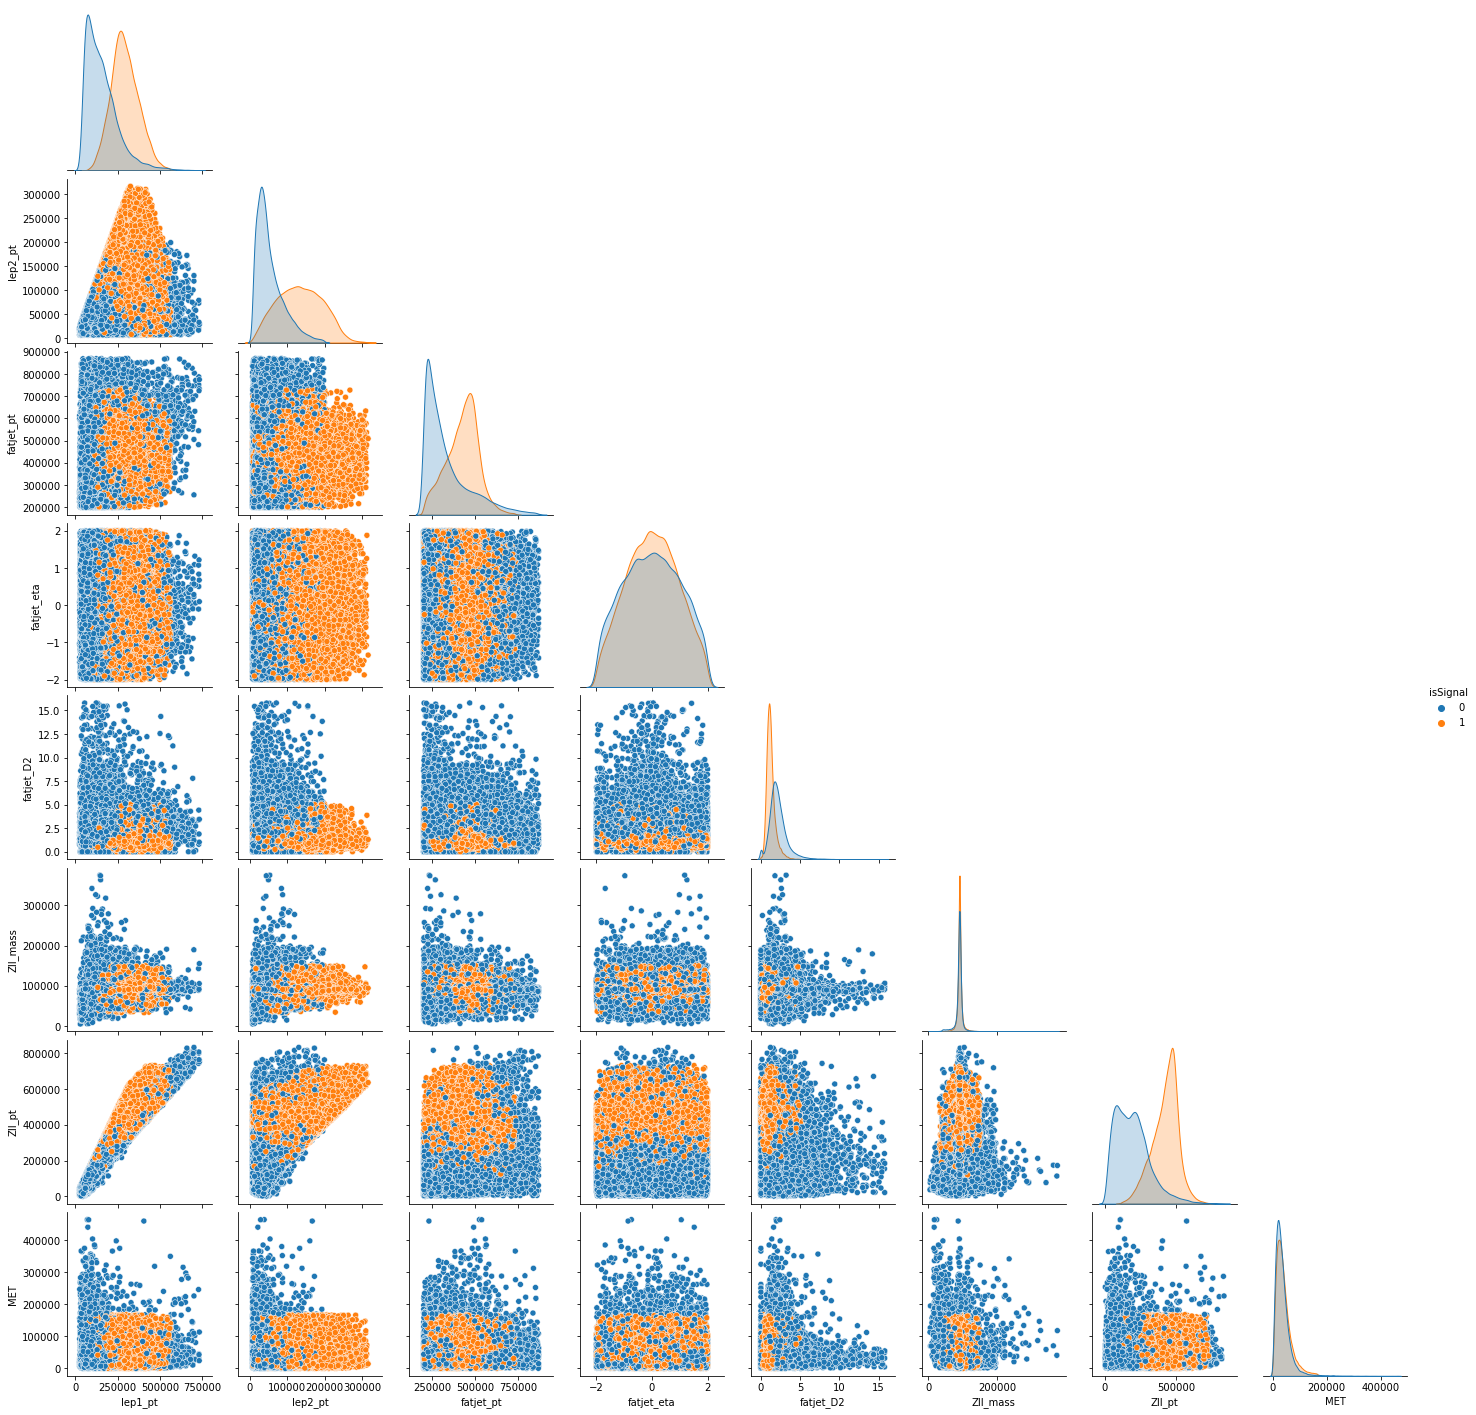

In [38]:
sns.pairplot(NN_training_df2, hue = 'isSignal', corner=True);

Maybe not necessary but plotted the variables against each other like in the checkpoint. Domains of signal and background points are obvious yb eye so we would expect a NN classifier to pick up on them too.

In [39]:
# Scale as given in notes
sc = preprocessing.StandardScaler()
input_data = sc.fit_transform(NN_training_df2.iloc[:, :-1])
target = NN_training_df2.iloc[:, -1]
# train - test split of dataset
train_data, test_data, train_target, test_target = model_selection.train_test_split(\
    input_data, target, test_size = 0.3, random_state = Answer_to_all_questions)
print(train_data.shape, train_target.shape, test_data.shape, test_target.shape)

(65629, 8) (65629,) (28127, 8) (28127,)


In [40]:
def NN_model(num_inputs, num_nodes, extra_depth):
    # create model
    model = Sequential()
    model.add(Dense(num_nodes, input_dim = num_inputs, kernel_initializer = 'normal', \
        activation = 'relu'))
    model.add(Dropout(0.2))
    for i in range(extra_depth):
        # code up the extra layers here
        model.add(Dense(num_nodes, input_dim = num_nodes, kernel_initializer = 'normal', \
            activation = 'relu')) 
    num_outputs = 1
    model.add(Dense(num_outputs, activation = 'sigmoid'))
    # Compile model
    model.compile(loss = 'binary_crossentropy' , optimizer = 'adam' , metrics =['accuracy'])
    return model

In [41]:
batchSize = 100
# With early stopping we can put arbitrarily large number of epochs here
N_epochs = 100

In [42]:
model1 = NN_model(train_data.shape[1], 40, 4)

In [43]:
callbacks_ = [
# if we don ’t have an increase of the accuracy for 10 epochs , terminate training .
EarlyStopping(verbose = True, patience =10, monitor = 'val_accuracy') ,
# Always make sure that we ’ re saving the model weights with the best accuracy .
ModelCheckpoint('model.h5', monitor = 'val_accuracy', verbose =0, save_best_only = True, mode = 'max')]
history1 = model1.fit(train_data, train_target, batch_size = batchSize, epochs = N_epochs, \
    verbose =1, validation_data =(test_data, test_target), callbacks = callbacks_ )

Epoch 1/100
657/657 [==============================] - 3s 3ms/step - loss: 0.2914 - accuracy: 0.8916 - val_loss: 0.2478 - val_accuracy: 0.9011
Epoch 2/100
657/657 [==============================] - 2s 3ms/step - loss: 0.2518 - accuracy: 0.8981 - val_loss: 0.2380 - val_accuracy: 0.9035
Epoch 3/100
657/657 [==============================] - 2s 3ms/step - loss: 0.2426 - accuracy: 0.9027 - val_loss: 0.2293 - val_accuracy: 0.9087
Epoch 4/100
657/657 [==============================] - 2s 3ms/step - loss: 0.2389 - accuracy: 0.9040 - val_loss: 0.2278 - val_accuracy: 0.9078
Epoch 5/100
657/657 [==============================] - 2s 3ms/step - loss: 0.2356 - accuracy: 0.9051 - val_loss: 0.2244 - val_accuracy: 0.9089
Epoch 6/100
657/657 [==============================] - 2s 3ms/step - loss: 0.2325 - accuracy: 0.9055 - val_loss: 0.2216 - val_accuracy: 0.9104
Epoch 7/100
657/657 [==============================] - 2s 3ms/step - loss: 0.2297 - accuracy: 0.9067 - val_loss: 0.2185 - val_accuracy: 0.9114

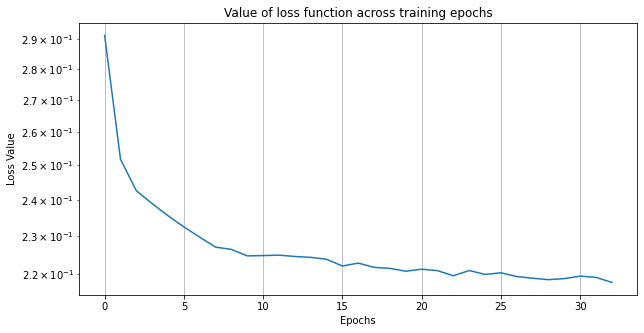

In [44]:
nn_utils.lossplot(history1.history['loss'], scale='log')

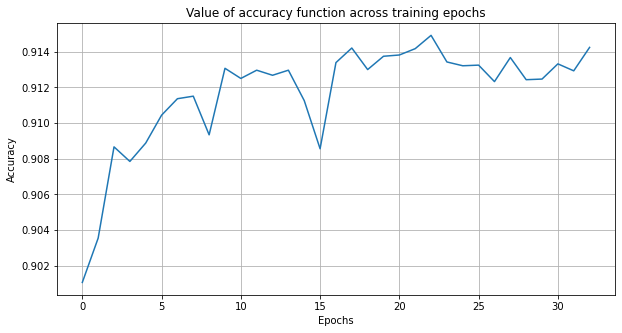

In [45]:
nn_utils.accplot(history1.history['val_accuracy'], scale='linear')

~90\% accurate is very good.

In [46]:
NN_full_df2 = NN_full_df.drop(['reco_zv_mass', 'FullEventWeight'], axis=1)

In [47]:
# Scale our original data too, to look siilar to the training data
sc = preprocessing.StandardScaler()
full_input_data = sc.fit_transform(NN_full_df2.iloc[:, :-1])
full_target = NN_full_df2.iloc[:, -1]

In [48]:
# Get probabilities of signal event for test set
test_pred = model1.predict(full_input_data)
# Round >= 0.5 up to 1 and < 0.5 down to 0
predicted = np.round(test_pred)

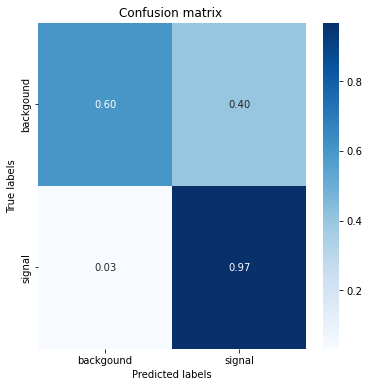

In [49]:
# Confusion matrix
cm = confusion_matrix(full_target, predicted, normalize="true")
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, cmap=plt.cm.Blues,annot=True,fmt=".2f")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
ax.set_yticklabels(['backgound', 'signal'])
ax.set_xticklabels(['backgound', 'signal'])
plt.title('Confusion matrix ')
plt.show()

As the real data is not a 50-50 mix of signal and background, the network is a lot less accurate than during training/validation. Excellent at identifying signal when its there but pretty much randomly decides whether background is really background or signal.

In [50]:
# ROC curve
fpr, tpr, thresholds = roc_curve(full_target, test_pred)
roc_auc = auc(fpr, tpr)

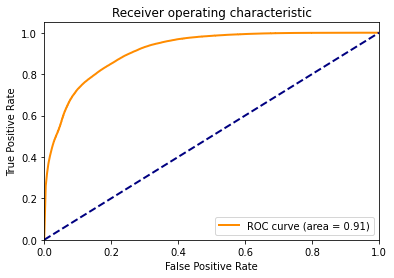

In [51]:
plt.figure()
lw = 2
plt.plot(
    fpr,
    tpr,
    color="darkorange",
    lw=lw,
    label="ROC curve (area = %0.2f)" % roc_auc,
)
plt.plot([0, 1], [0, 1], color="navy", lw=lw, linestyle="--")
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver operating characteristic")
plt.legend(loc="lower right")
plt.show()

Curve area near 1 and graph in upper left mostly so looks good.

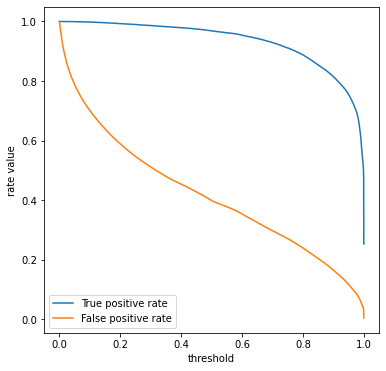

In [52]:
fig, ax = plt.subplots(figsize=(6, 6))
ax.plot(thresholds[1:], tpr[1:], label='True positive rate')
ax.plot(thresholds[1:], fpr[1:], label='False positive rate')
ax.set_xlabel('threshold')
ax.set_ylabel('rate value')
ax.legend()
plt.show()

At threshold of 0, everything is considered signal so fpr and tpr are both 1 while at threshold of exactly 1, nothing is considered signal so fpr and tpr are both close to 0 as expected.

In [53]:
NN_full_df['Signal_prediction'] = predicted

In [54]:
NN_sig_pred_df = NN_full_df[NN_full_df['Signal_prediction']==1]

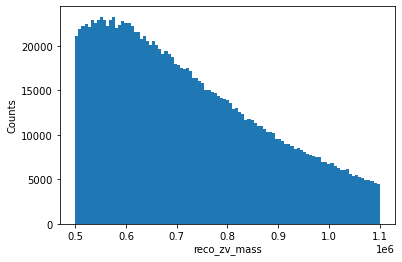

In [55]:
fig, ax = plt.subplots()
ax.hist(NN_sig_pred_df['reco_zv_mass'],
        weights=NN_sig_pred_df['FullEventWeight'],
        bins=bin_edges_f,
        label='NN signal predictions')
ax.set_ylabel('Counts')
ax.set_xlabel('reco_zv_mass')
plt.show()

We see that applying the NN to filter data without any kinematic cuts means the peak is still invisible. Therefore, we will take new cuts that are less harsh and not on the graphs where there is a lot of overlap between some of the distributions (see first graph with cuts).

In [56]:
new_sqcuts = np.array([150000, 50000, 330000,
                       -2.0,   2.0,   0,
                       200000, 0])
new_signal_above = np.array([True, True, True,
                             True, False, True,
                             True, True])
new_background_above = np.array([False, False, False,
                                 True,  True,  True,
                                 False, True])

In [57]:
signal_df2_newcut = cut_data(signal_df2, new_sqcuts, new_signal_above)
background_df2_newcut = cut_data(background_df2, new_sqcuts, new_background_above)
full_df2_newcut = pd.concat([background_df2_newcut, signal_df2_newcut], ignore_index=True)

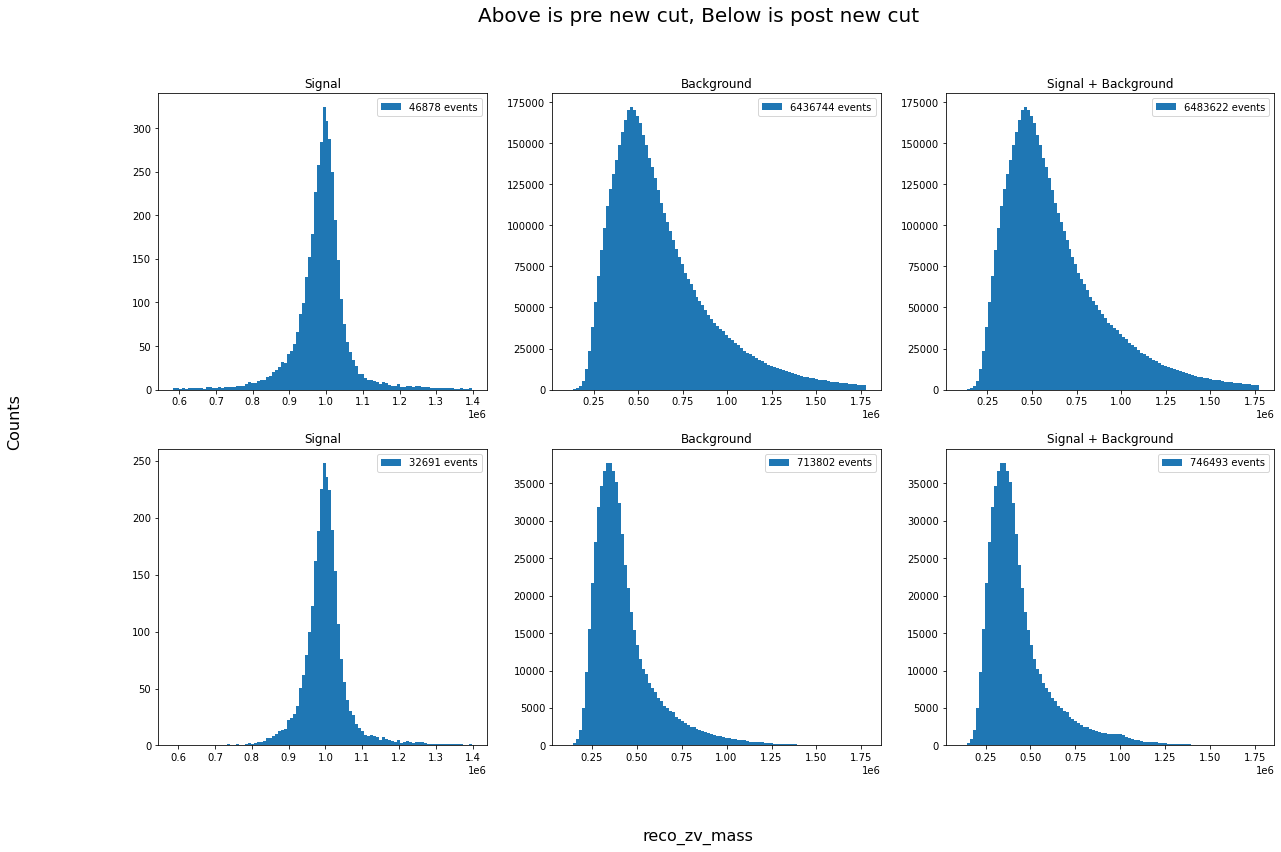

In [58]:
fig, axs = plt.subplots(2, 3, figsize=(20, 12))
fig.suptitle('Above is pre new cut, Below is post new cut', fontsize=20)
fig.supylabel('Counts', fontsize=16)
fig.supxlabel('reco_zv_mass', fontsize=16)
plot_sig_bkgd(axs[0], signal_df2, background_df2, full_df2)
plot_sig_bkgd(axs[1], signal_df2_newcut, background_df2_newcut, full_df2_newcut)
plt.show()

Now there is just a hint of a peak with the new less harsh cuts.

In [59]:
NN_signal_df_newcut = signal_df2_newcut.copy()
NN_background_df_newcut = background_df2_newcut.copy()
NN_full_df_newcut = full_df2_newcut.copy()
NN_background_df_newcut = shuffle(NN_background_df_newcut, random_state=Answer_to_all_questions)
NN_background_df_newcut = NN_background_df_newcut.reset_index(drop=True)
# 50-50 mix of signal and background data points
NN_training_df_newcut = pd.concat([NN_signal_df_newcut, NN_background_df_newcut.iloc[:NN_signal_df_newcut.shape[0]]], ignore_index=True)
NN_training_df_newcut = shuffle(NN_training_df_newcut, random_state=Answer_to_all_questions)
NN_training_df_newcut = NN_training_df_newcut.reset_index(drop=True)
NN_training_df2_newcut = NN_training_df_newcut.drop(['reco_zv_mass', 'FullEventWeight'], axis=1)
# Scale as given in notes
sc = preprocessing.StandardScaler()
input_data2 = sc.fit_transform(NN_training_df2_newcut.iloc[:, :-1])
target2 = NN_training_df2_newcut.iloc[:, -1]
# train - test split of dataset
train_data2, test_data2, train_target2, test_target2 = model_selection.train_test_split(\
    input_data2, target2, test_size = 0.3, random_state = Answer_to_all_questions)
print(train_data2.shape, train_target2.shape, test_data2.shape, test_target2.shape)

(45767, 8) (45767,) (19615, 8) (19615,)


In [60]:
model2 = NN_model(train_data2.shape[1], 40, 4)

In [61]:
callbacks_ = [
# if we don ’t have an increase of the accuracy for 10 epochs , terminate training .
EarlyStopping(verbose = True, patience =10, monitor = 'val_accuracy') ,
# Always make sure that we ’ re saving the model weights with the best accuracy .
ModelCheckpoint('model2.h5', monitor = 'val_accuracy', verbose =0, save_best_only = True, mode = 'max')]
history2 = model2.fit(train_data2, train_target2, batch_size = batchSize, epochs = N_epochs, \
    verbose =0, validation_data =(test_data2, test_target2), callbacks = callbacks_ )

Epoch 00015: early stopping


In [62]:
NN_full_df2_newcut = NN_full_df_newcut.drop(['reco_zv_mass', 'FullEventWeight'], axis=1)
sc = preprocessing.StandardScaler()
full_input_data_newcut = sc.fit_transform(NN_full_df2_newcut.iloc[:, :-1])
full_target_newcut = NN_full_df2_newcut.iloc[:, -1]

In [63]:
# Get probabilities of signal event for test set
test_pred2 = model2.predict(full_input_data_newcut)
# Round >= 0.5 up to 1 and < 0.5 down to 0
predicted2 = np.round(test_pred2)

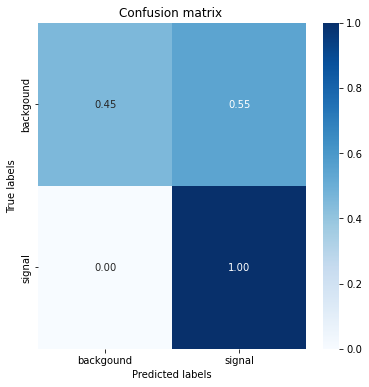

In [64]:
# Confusion matrix
cm = confusion_matrix(full_target_newcut, predicted2, normalize="true")
fig, ax = plt.subplots(figsize=(6, 6))
sns.heatmap(cm, cmap=plt.cm.Blues,annot=True,fmt=".2f")
plt.xlabel("Predicted labels")
plt.ylabel("True labels")
ax.set_yticklabels(['backgound', 'signal'])
ax.set_xticklabels(['backgound', 'signal'])
plt.title('Confusion matrix ')
plt.show()

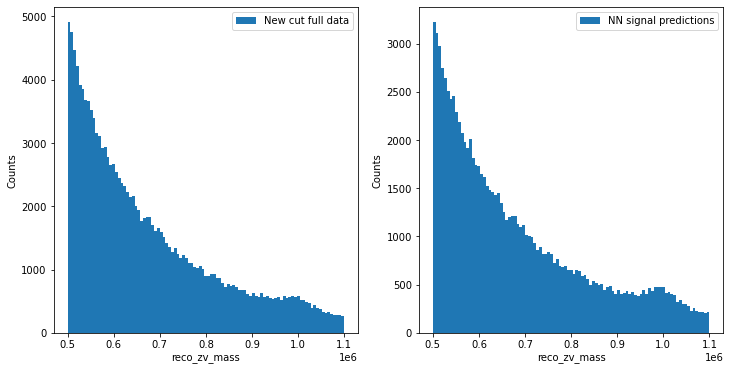

In [65]:
NN_full_df_newcut['Signal_prediction'] = predicted2
NN_sig_pred_df_newcut = NN_full_df_newcut[NN_full_df_newcut['Signal_prediction']==1]
fig, ax = plt.subplots(1, 2, figsize=(12, 6))
ax[0].hist(full_df2_newcut['reco_zv_mass'],
        weights=full_df2_newcut['FullEventWeight'],
        bins=bin_edges_f,
        label='New cut full data')
ax[0].set_ylabel('Counts')
ax[0].set_xlabel('reco_zv_mass')
ax[0].legend()
ax[1].hist(NN_sig_pred_df_newcut['reco_zv_mass'],
        weights=NN_sig_pred_df_newcut['FullEventWeight'],
        bins=bin_edges_f,
        label='NN signal predictions')
ax[1].set_ylabel('Counts')
ax[1].set_xlabel('reco_zv_mass')
ax[1].legend()
plt.show()

This time the NN does make the peak a little more visible as it is essentially not discarding any signal and roughly eliminating half of the background (see confusion matrix).

In [66]:
N_obs_f2, _ = np.histogram(full_df2_newcut['reco_zv_mass'],
                          weights=full_df2_newcut['FullEventWeight'],
                          bins=bin_edges_f)
bin_indices_f2 = np.digitize(full_df2_newcut['reco_zv_mass'], bin_edges_f)
sum_binned_weights_f2, sumsq_binned_weights_f2 = calc_sumsq_weights(bin_edges_f,
                                                                   full_df2_newcut['FullEventWeight'],
                                                                   bin_indices_f2)

sumsq_binned_weights_f2[sumsq_binned_weights_f2==0] = 1e-9

N_obs_f3, _ = np.histogram(NN_sig_pred_df_newcut['reco_zv_mass'],
                          weights=NN_sig_pred_df_newcut['FullEventWeight'],
                          bins=bin_edges_f)
bin_indices_f3 = np.digitize(NN_sig_pred_df_newcut['reco_zv_mass'], bin_edges_f)
sum_binned_weights_f3, sumsq_binned_weights_f3 = calc_sumsq_weights(bin_edges_f,
                                                                   NN_sig_pred_df_newcut['FullEventWeight'],
                                                                   bin_indices_f3)

sumsq_binned_weights_f3[sumsq_binned_weights_f3==0] = 1e-9

In [67]:
def chi2_H0_func2(k, Nb):
    N_pred = H0_func(k, Nb)
    return np.sum(((sum_binned_weights_f2 - N_pred)**2) / sumsq_binned_weights_f2)

def chi2_H1_func2(k, Ns, Nb):
    N_pred = H1_func(k, Ns, Nb)
    return np.sum(((sum_binned_weights_f2 - N_pred)**2) / sumsq_binned_weights_f2)

def chi2_H0_func3(k, Nb):
    N_pred = H0_func(k, Nb)
    return np.sum(((sum_binned_weights_f3 - N_pred)**2) / sumsq_binned_weights_f3)

def chi2_H1_func3(k, Ns, Nb):
    N_pred = H1_func(k, Ns, Nb)
    return np.sum(((sum_binned_weights_f3 - N_pred)**2) / sumsq_binned_weights_f3)

In [68]:
# fit with minutuit given reasonable initial guesses
fit5 = Minuit(chi2_H0_func2, k=6e-6, Nb=200000)
# definition of error for chi2 given in notes
fit5.errordef = 1.0
fit5.migrad()

k_H0fit2 = fit5.values["k"]
Nb_H0fit2 = fit5.values["Nb"]

# fit with minutuit given reasonable initial guesses
fit6 = Minuit(chi2_H1_func2, k=6e-6, Ns=300, Nb=200000)
# definition of error for chi2 given in notes
fit6.errordef = 1.0
fit6.migrad()

k_H1fit2 = fit6.values["k"]
Ns_H1fit2 = fit6.values["Ns"]
Nb_H1fit2 = fit6.values["Nb"]

# fit with minutuit given reasonable initial guesses
fit7 = Minuit(chi2_H0_func3, k=6e-6, Nb=100000)
# definition of error for chi2 given in notes
fit7.errordef = 1.0
fit7.migrad()

k_H0fit3 = fit7.values["k"]
Nb_H0fit3 = fit7.values["Nb"]

# fit with minutuit given reasonable initial guesses
fit8 = Minuit(chi2_H1_func3, k=6e-6, Ns=300, Nb=200000)
# definition of error for chi2 given in notes
fit8.errordef = 1.0
fit8.migrad()

k_H1fit3 = fit8.values["k"]
Ns_H1fit3 = fit8.values["Ns"]
Nb_H1fit3 = fit8.values["Nb"]

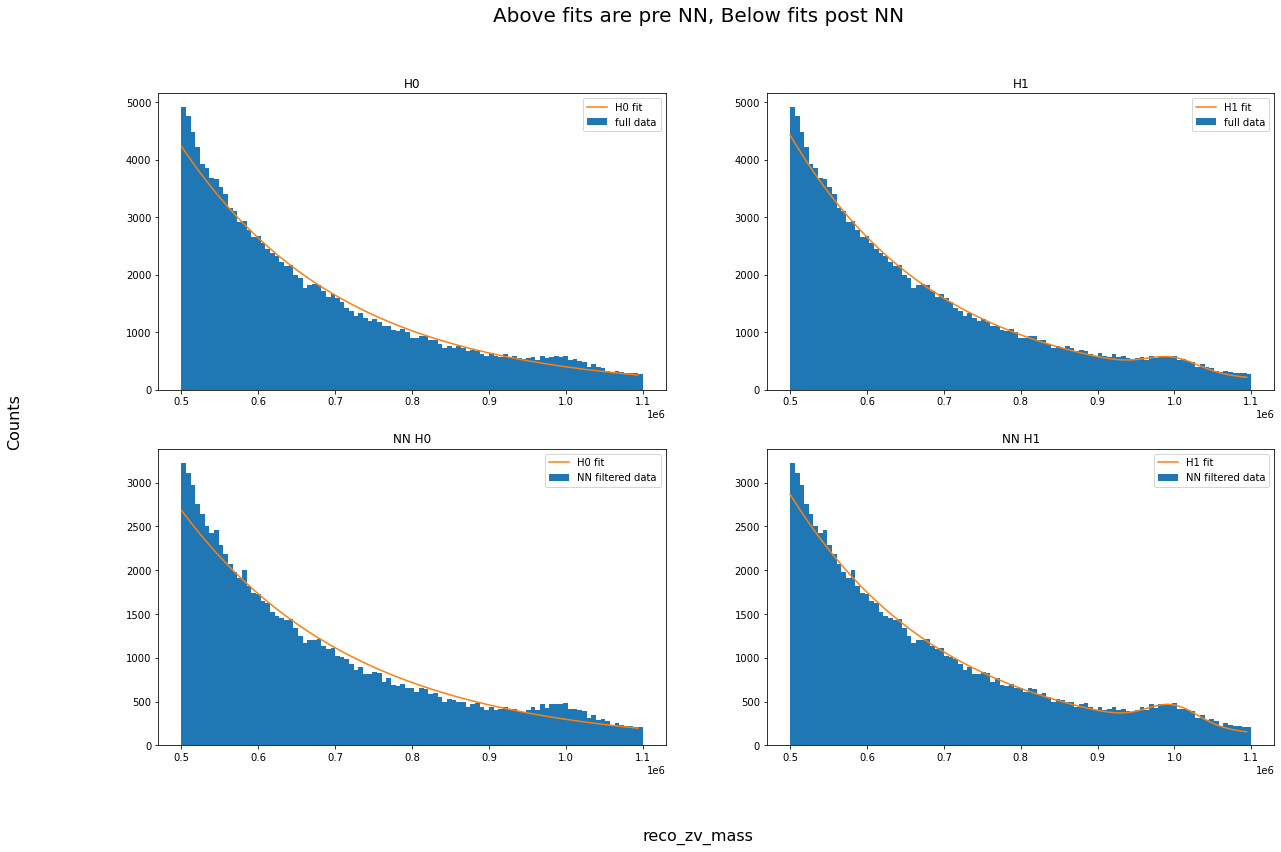

In [69]:
fig, axs = plt.subplots(2, 2, figsize=(20, 12))
fig.suptitle('Above fits are pre NN, Below fits post NN', fontsize=20)
fig.supylabel('Counts', fontsize=16)
fig.supxlabel('reco_zv_mass', fontsize=16)
axs[0,0].set_title('H0')
axs[0,0].hist(full_df2_newcut['reco_zv_mass'],
              weights=full_df2_newcut['FullEventWeight'],
              bins=bin_edges_f,
              label='full data')
axs[0,0].plot(bin_edges_f[:-1], H0_func(k_H0fit2, Nb_H0fit2), label='H0 fit')
axs[0,0].legend()

axs[0,1].set_title('H1')
axs[0,1].hist(full_df2_newcut['reco_zv_mass'],
              weights=full_df2_newcut['FullEventWeight'],
              bins=bin_edges_f,
              label='full data')
axs[0,1].plot(bin_edges_f[:-1], H1_func(k_H1fit2, Ns_H1fit2, Nb_H1fit2), label='H1 fit')
axs[0,1].legend()

axs[1,0].set_title('NN H0')
axs[1,0].hist(NN_sig_pred_df_newcut['reco_zv_mass'],
              weights=NN_sig_pred_df_newcut['FullEventWeight'],
              bins=bin_edges_f,
              label='NN filtered data')
axs[1,0].plot(bin_edges_f[:-1], H0_func(k_H0fit3, Nb_H0fit3), label='H0 fit')
axs[1,0].legend()

axs[1,1].set_title('NN H1')
axs[1,1].hist(NN_sig_pred_df_newcut['reco_zv_mass'],
              weights=NN_sig_pred_df_newcut['FullEventWeight'],
              bins=bin_edges_f,
              label='NN filtered data')
axs[1,1].plot(bin_edges_f[:-1], H1_func(k_H1fit3, Ns_H1fit3, Nb_H1fit3), label='H1 fit')
axs[1,1].legend()
plt.show()

In [70]:
delta_chi2preNN = chi2_H0_func2(k_H0fit2, Nb_H0fit2) - chi2_H1_func2(k_H1fit2, Ns_H1fit2, Nb_H1fit2)
p_valuepreNN = scipy.stats.chi2.cdf(delta_chi2preNN, df=1)
n_sigmaspreNN = erfinv(p_value) * np.sqrt(2)

delta_chi2postNN = chi2_H0_func3(k_H0fit3, Nb_H0fit3) - chi2_H1_func3(k_H1fit3, Ns_H1fit3, Nb_H1fit3)
p_valuepostNN = scipy.stats.chi2.cdf(delta_chi2postNN, df=1)
n_sigmaspostNN = erfinv(p_value) * np.sqrt(2)

In [71]:
p_valuepreNN

1.0

In [72]:
p_valuepostNN

1.0

Despite the graphs being more realistic, the p values still say that even the reduced peak is impossible to occur by background fluctuation alone. pre or post NN filtering.

## Impact of training sample on classifier

In [73]:
NN_signal_df_newcut = signal_df2_newcut.copy()
NN_background_df_newcut = background_df2_newcut.copy()
NN_full_df_newcut = full_df2_newcut.copy()
NN_background_df_newcut = shuffle(NN_background_df_newcut, random_state=Answer_to_all_questions)
NN_background_df_newcut = NN_background_df_newcut.reset_index(drop=True)
# 50-50 mix of signal and background data points
NN_training_df_newcut = pd.concat([NN_signal_df_newcut, NN_background_df_newcut.iloc[:NN_signal_df_newcut.shape[0]]], ignore_index=True)
NN_training_df_newcut = shuffle(NN_training_df_newcut, random_state=Answer_to_all_questions)
NN_training_df_newcut = NN_training_df_newcut.reset_index(drop=True)
NN_training_df2_newcut = NN_training_df_newcut.drop(['FullEventWeight'], axis=1)
# Scale as given in notes
sc = preprocessing.StandardScaler()
input_data2 = sc.fit_transform(NN_training_df2_newcut.iloc[:, :-1])
target2 = NN_training_df2_newcut.iloc[:, -1]
# train - test split of dataset
train_data2, test_data2, train_target2, test_target2 = model_selection.train_test_split(\
    input_data2, target2, test_size = 0.3, random_state = Answer_to_all_questions)
print(train_data2.shape, train_target2.shape, test_data2.shape, test_target2.shape)

(45767, 9) (45767,) (19615, 9) (19615,)


In [74]:
model3 = NN_model(train_data2.shape[1], 40, 4)

In [75]:
callbacks_ = [
# if we don ’t have an increase of the accuracy for 10 epochs , terminate training .
EarlyStopping(verbose = True, patience =10, monitor = 'val_accuracy') ,
# Always make sure that we ’ re saving the model weights with the best accuracy .
ModelCheckpoint('model3.h5', monitor = 'val_accuracy', verbose =0, save_best_only = True, mode = 'max')]
history3 = model3.fit(train_data2, train_target2, batch_size = batchSize, epochs = N_epochs, \
    verbose =0, validation_data =(test_data2, test_target2), callbacks = callbacks_ )

Epoch 00013: early stopping


In [76]:
NN_full_df2_newcut = NN_full_df_newcut.drop(['FullEventWeight'], axis=1)
sc = preprocessing.StandardScaler()
full_input_data_newcut = sc.fit_transform(NN_full_df2_newcut.iloc[:, :-1])
full_target_newcut = NN_full_df2_newcut.iloc[:, -1]
# Get probabilities of signal event for test set
test_pred3 = model3.predict(full_input_data_newcut)
# Round >= 0.5 up to 1 and < 0.5 down to 0
predicted3 = np.round(test_pred3)

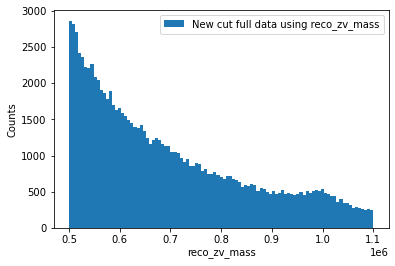

In [77]:
NN_full_df_newcut['Signal_prediction'] = predicted3
NN_sig_pred_df_newcut = NN_full_df_newcut[NN_full_df_newcut['Signal_prediction']==1]
fig, ax = plt.subplots()
ax.hist(NN_sig_pred_df_newcut['reco_zv_mass'],
        weights=NN_sig_pred_df_newcut['FullEventWeight'],
        bins=bin_edges_f,
        label='New cut full data using reco_zv_mass')
ax.set_ylabel('Counts')
ax.set_xlabel('reco_zv_mass')
ax.legend()
plt.show()

Including reco_zv_mass does not significantly help the classifier better filter background so likely most of the information in reco_zv_mass is also found in the other training features. 